# Import libraries

In [1]:
import json
import os
import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example of data format for a single scan's MRIQC output

In [2]:
filepath = "./json_results/sub-1000173_ses-NAPBL00_run-001_T1w.json"

with open(filepath, "r+") as file:
    data = json.load(file)
    del data['bids_meta']
    del data['provenance']
    pprint.pprint(data)

{'cjv': 0.505419840662851,
 'cnr': 2.608381362441234,
 'efc': 0.6700414046226537,
 'fber': 65.83421325683594,
 'fwhm_avg': 3.130486666666666,
 'fwhm_x': 3.22958,
 'fwhm_y': 3.21713,
 'fwhm_z': 2.94475,
 'icvs_csf': 0.2197020056438308,
 'icvs_gm': 0.3968994095766471,
 'icvs_wm': 0.3833985847795221,
 'inu_med': 1.3771222829818726,
 'inu_range': 0.44646955132484445,
 'qi_1': 0.0,
 'qi_2': 0.004732829912338535,
 'rpve_csf': 24.112069062368693,
 'rpve_gm': 13.161960052867572,
 'rpve_wm': 16.601523898483062,
 'size_x': 176,
 'size_y': 240,
 'size_z': 256,
 'snr_csf': 2.7699712491554163,
 'snr_gm': 8.563957777069179,
 'snr_total': 8.73997848255342,
 'snr_wm': 14.88600642143567,
 'snrd_csf': 8.045218245328096,
 'snrd_gm': 19.21383533791636,
 'snrd_total': 18.115955143524342,
 'snrd_wm': 27.08881184732856,
 'spacing_x': 1.0,
 'spacing_y': 1.0,
 'spacing_z': 1.0,
 'summary_bg_k': 1518.5623362872516,
 'summary_bg_mad': 24.185107048374242,
 'summary_bg_mean': 81.34371185302734,
 'summary_bg_median

# Function to find discrepancies in NeuroCI's output file

In [3]:
NeuroCI_discrepancy_results_file = "volumes_full.json"

#Find a discrepancy between FSL and FreeSurfer hippocampal volumes for a given scan
def find_discrepancy(json_results, filename):
    with open(json_results, "r+") as file:
        data = json.load(file)
        output = {}

        FSL = float(data[filename]['FSL'])
        FreeSurfer = float(data[filename]['FreeSurfer'])
        ASHS = float(data[filename]['ASHS'])

        output['FSL-FreeSurfer'] = abs(FSL-FreeSurfer)
        output['FSL-ASHS'] = abs(FSL-ASHS)
        output['ASHS-FreeSurfer'] = abs(ASHS-FreeSurfer)
        output['avg'] = (output['FSL-FreeSurfer'] + output['FSL-ASHS'] + output['ASHS-FreeSurfer']) / 3

        return output

#Example using the fn
find_discrepancy(NeuroCI_discrepancy_results_file, "sub-6852929_ses-NAPFU12_run-001_T1w.nii.gz")

{'FSL-FreeSurfer': 4142.1,
 'FSL-ASHS': 3395.5,
 'ASHS-FreeSurfer': 746.6000000000004,
 'avg': 2761.4}

# Function to find DICE values in NeuroCI's output file

In [4]:
NeuroCI_DICE_results_file = "Dice.json"

#Find a discrepancy between FSL and FreeSurfer hippocampal volumes for a given scan
def find_DICE(json_results, filename):
    with open(json_results, "r+") as file:
        data = json.load(file)
        output = {}
        output['FSL-FreeSurfer'] = float(data[filename]['FSL-FreeSurfer'])
        # output['FSL-ASHS'] = float(data[filename]['FSL-ASHS'])
        # output['ASHS-FreeSurfer'] = float(data[filename]['ASHS-FreeSurfer'])
        # output['avg'] = (output['FSL-FreeSurfer'] + output['FSL-ASHS'] + output['ASHS-FreeSurfer']) / 3

        return output

#Example using the fn
find_DICE(NeuroCI_DICE_results_file, "sub-6852929_ses-NAPFU12_run-001_T1w.nii.gz")

{'FSL-FreeSurfer': 0.0}

# Making a list of all such dictionaries available in the 'mriqc_output' directory

In [5]:
mriqc_output_directory = "./json_results"
NeuroCI_discrepancy_results_file = "volumes_full.json"
NeuroCI_DICE_results_file = "Dice.json"
list_of_mriqc = []
list_of_err = []

for filename in os.listdir(mriqc_output_directory):
    file_path = os.path.join(mriqc_output_directory, filename)
    with open(file_path, "r+") as file:
        data = {}
        mriqc = json.load(file)
        del mriqc['bids_meta']
        del mriqc['provenance']
        data['mriqc'] = mriqc
        data['filename'] = filename[:-5] + ".nii.gz" 
        try:
            data['discrepancy'] = find_discrepancy(NeuroCI_discrepancy_results_file, data['filename']) 
            data['DICE'] = find_DICE(NeuroCI_DICE_results_file, data['filename']) 
            list_of_mriqc.append(data)
        except:
            list_of_err.append(data['filename'])
        
print(str(len(list_of_mriqc)) + ' subjects were successful and ' + str(len(list_of_err)) + ' subjects had missing data.')
pprint.pprint(list_of_mriqc[2]) #each element of the list is the dictionary of a single MRIQC result file.

894 subjects were successful and 378 subjects had missing data.
{'DICE': {'FSL-FreeSurfer': 0.0},
 'discrepancy': {'ASHS-FreeSurfer': 581.3000000000002,
                 'FSL-ASHS': 2729.0,
                 'FSL-FreeSurfer': 3310.3,
                 'avg': 2206.866666666667},
 'filename': 'sub-6852929_ses-NAPBL00_run-001_T1w.nii.gz',
 'mriqc': {'cjv': 0.4589474686328697,
           'cnr': 2.8183498405824587,
           'efc': 0.6282549718822019,
           'fber': 100.4571304321289,
           'fwhm_avg': 3.224016666666666,
           'fwhm_x': 3.27621,
           'fwhm_y': 3.36942,
           'fwhm_z': 3.02642,
           'icvs_csf': 0.1974390172618788,
           'icvs_gm': 0.40607015788550493,
           'icvs_wm': 0.3964908248526163,
           'inu_med': 1.3579199314117432,
           'inu_range': 0.4501024782657621,
           'qi_1': 5.676655793768357e-05,
           'qi_2': 0.004451045881323329,
           'rpve_csf': 27.42469795639944,
           'rpve_gm': 13.93006687098379,


# List of all MRIQC features names

In [6]:
features_list = [key for key in list_of_mriqc[0]['mriqc']]

print(str(len(features_list))+ ' MRIQC features found.')

68 MRIQC features found.


# creating observations and target arrays

Exclude outliers

In [7]:
with open('exclusion_list.txt') as f:
    files_to_exclude = [line[:line.find('.gz')+3] for line in f.readlines()]
print(str(len(files_to_exclude))+' files to exclude.')

349 files to exclude.


In [8]:
outliers = []
new_list_of_mriqc = []
for data in list_of_mriqc:
    # if data['discrepancy']['FSL-FreeSurfer']>5000 or data['discrepancy']['FSL-ASHS']>10000 or data['discrepancy']['ASHS-FreeSurfer']>10000 or data['filename'] in files_to_exclude:
    # if data['filename'] in files_to_exclude:
    #     outliers.append(data['filename'])
    #     continue
    # if data['discrepancy']['FSL-FreeSurfer']>1000 or data['discrepancy']['FSL-ASHS']>1000 or data['discrepancy']['ASHS-FreeSurfer']>1000:
    #     continue
    new_list_of_mriqc.append(data)

list_of_mriqc = new_list_of_mriqc

print(str(len(list_of_mriqc)) + ' subjects were successful and ' + str(len(outliers)) + ' subjects were excluded.')

894 subjects were successful and 0 subjects were excluded.


Create observations and target variables

In [9]:
observations = list()
for data in list_of_mriqc:
    x = list()
    for feature in features_list:
        x.append(data['mriqc'][feature])
    observations.append(np.array(x))
observations = np.array(observations)

print('observations shape = ', observations.shape)

target = {}
if 'discrepancy' in data:
    target['discrepancy'] = {}
    for discrepancy_key in data['discrepancy']:
        y = list()
        for data in list_of_mriqc:
            y.append(data['discrepancy'][discrepancy_key])
        target['discrepancy'][discrepancy_key] = np.array(y)

if 'DICE' in data:
    target['DICE'] = {}
    for DICE_key in data['DICE']:
        y = list()
        for data in list_of_mriqc:
            y.append(data['DICE'][DICE_key])
        target['DICE'][DICE_key] = np.array(y)

print('target shape = ', target['DICE']['FSL-FreeSurfer'].shape)

observations shape =  (894, 68)
target shape =  (894,)


removing bad features

In [10]:
# finding bad features
keys_not_to_include = list()
for i, feature in enumerate(features_list):
    if np.nan_to_num(np.std(observations[:,i]))==0:
        keys_not_to_include.append(feature)

    if np.sum(observations[:,i])==0:
        keys_not_to_include.append(feature)
keys_not_to_include.append('spacing_y') # manually detected

# removing bad features from observations matrix
new_observations = list()
for i, feature in enumerate(features_list):
    if not feature in keys_not_to_include:
        new_observations.append(observations[:, i])
new_observations = np.array(new_observations).T
observations = new_observations

# removing bad features from features_list
removed_features = list()
for key in keys_not_to_include:
    if key in features_list:
        removed_features.append(key)
        features_list.remove(key)

print(str(len(removed_features))+' features were removed.')
print(removed_features)

6 features were removed.
['size_x', 'size_y', 'size_z', 'spacing_x', 'spacing_z', 'spacing_y']


# finding top correlated features

finding the most correlated feature using values of the target feature

In [11]:
target_feature = 'DICE' # 'DICE' or 'discrepancy'

regression

In [12]:
# # from sklearn.linear_model import LinearRegression
# # from sklearn import linear_model
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_score

# target_feature = 'DICE'
# target_feature_key = 'FSL-FreeSurfer' # 'FSL-ASHS'  'FSL-FreeSurfer' 

# # reg = linear_model.Lasso(alpha=1, normalize=True, max_iter=10000)
# # reg.fit(observations, target[target_feature][target_feature_key])

# # reg = LinearRegression().fit(observations, target[target_feature][target_feature_key])

# top_feature[target_feature_key]['corr']
# reg = RandomForestRegressor(random_state=0)
# print(cross_val_score(reg, observations, target[target_feature][target_feature_key], cv=10))
# # reg.fit(observations, target[target_feature][target_feature_key])
# # print(reg.score(observations, target[target_feature][target_feature_key]))

# # print(len(reg.coef_), reg.coef_)

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor

target_feature = 'DICE'
target_feature_key = 'FSL-FreeSurfer' # 'FSL-ASHS'  'FSL-FreeSurfer' 

X = observations
y = target[target_feature][target_feature_key]

RFR = Pipeline([("reduce_dims", PCA(n_components=15)),("rand_forest", RandomForestRegressor()),])
RFR.fit(X, y)
scores_pipe = cross_validate(RFR, X, y, cv=10)["test_score"]
print("feature selection on train set:", scores_pipe)
print("feature selection on train set (mean):", np.mean(scores_pipe))

feature selection on train set: [ 0.08875656  0.03547772  0.09292201  0.05138551  0.03430887  0.10487151
  0.09907052  0.10728524 -0.01694885  0.10617089]
feature selection on train set (mean): 0.0703299979988164


scatter plot of target feature pairs

In [14]:
for i, target_feature_key_i in enumerate(target[target_feature]):
    for j, target_feature_key_j in enumerate(target[target_feature]):

        if j>=i or target_feature_key_i=='avg' or target_feature_key_j=='avg':
            continue
        
        x = target[target_feature][target_feature_key_i]
        y = target[target_feature][target_feature_key_j]

        h = sns.jointplot(x=x, y=y, kind="reg", marker="+")
        # JointGrid has a convenience function
        if target_feature == 'discrepancy':
            h.set_axis_labels(target_feature_key_i+' discrepancy ('+r'$mm^3$'+')', target_feature_key_j+' discrepancy ('+r'$mm^3$'+')', fontsize=15)
        elif target_feature == 'DICE':
            h.set_axis_labels(target_feature_key_i+' DICE overlap', target_feature_key_j+' DICE overlap', fontsize=15)

        plt.savefig('pair-scatter-'+target_feature_key_i+'-'+target_feature_key_j+'-'+target_feature+'.png', transparent=True)

correlation of all mriqc features

top feature in FSL-FreeSurfer is "efc" with correlation of -0.23


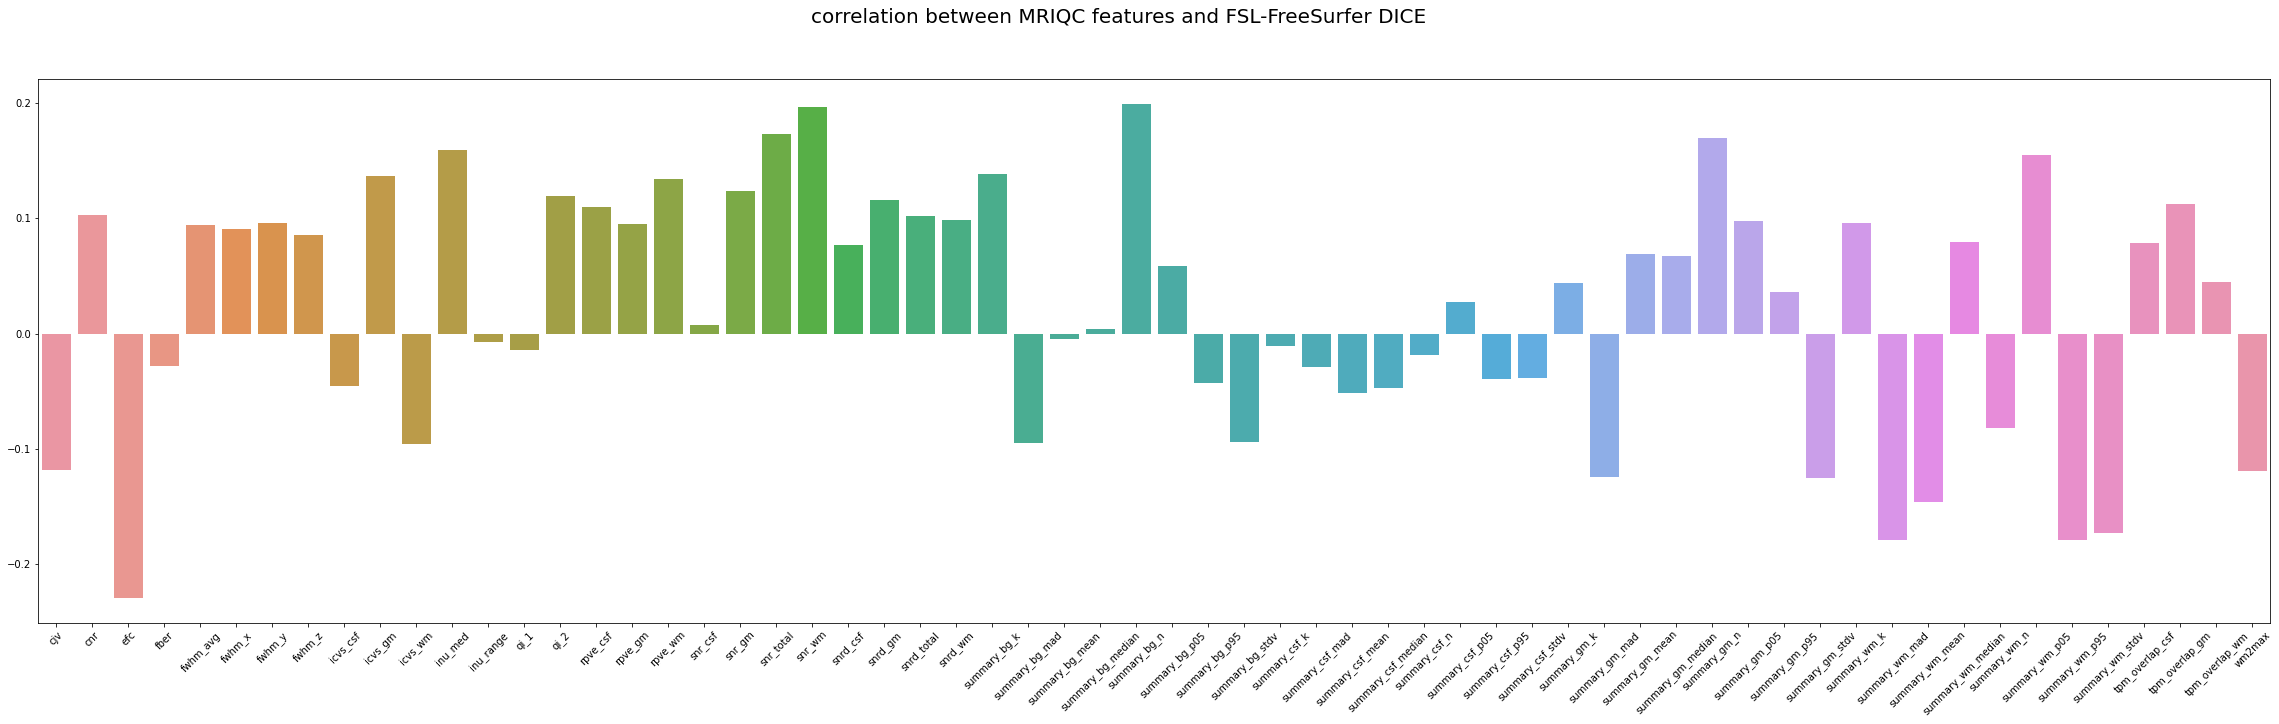

In [15]:
corr_dict = {}
top_feature = {}
for target_feature_key in target[target_feature]:
    corr_dict[target_feature_key] = list()
    for i, feature in enumerate(features_list):
        print(target[target_feature][target_feature_key])
        corr_dict[target_feature_key].append(np.corrcoef(target[target_feature][target_feature_key], observations[:, i])[0,1])
    corr_dict[target_feature_key] = np.array(corr_dict[target_feature_key])

    plt.figure(figsize=(40,10))
    sns.barplot(x=features_list, y=corr_dict[target_feature_key])
    plt.xticks(rotation=45)
    plt.suptitle('correlation between MRIQC features and ' + target_feature_key + ' ' + target_feature, size=20)
    plt.savefig('all-corr-'+target_feature_key+target_feature+'.png', transparent=True)

    top_feature[target_feature_key] = {}
    top_feature[target_feature_key]['idx'] = np.argmax(np.abs(corr_dict[target_feature_key]))
    top_feature[target_feature_key]['name'] = features_list[top_feature[target_feature_key]['idx']]
    top_feature[target_feature_key]['corr'] = corr_dict[target_feature_key][top_feature[target_feature_key]['idx']]

    print('top feature in '+target_feature_key+' is "'+top_feature[target_feature_key]['name']+'" with correlation of %.2f' %top_feature[target_feature_key]['corr'])

/Users/mte/opt/anaconda3/envs/neuro/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/mte/opt/anaconda3/envs/neuro/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/mte/opt/anaconda3/envs/neuro/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


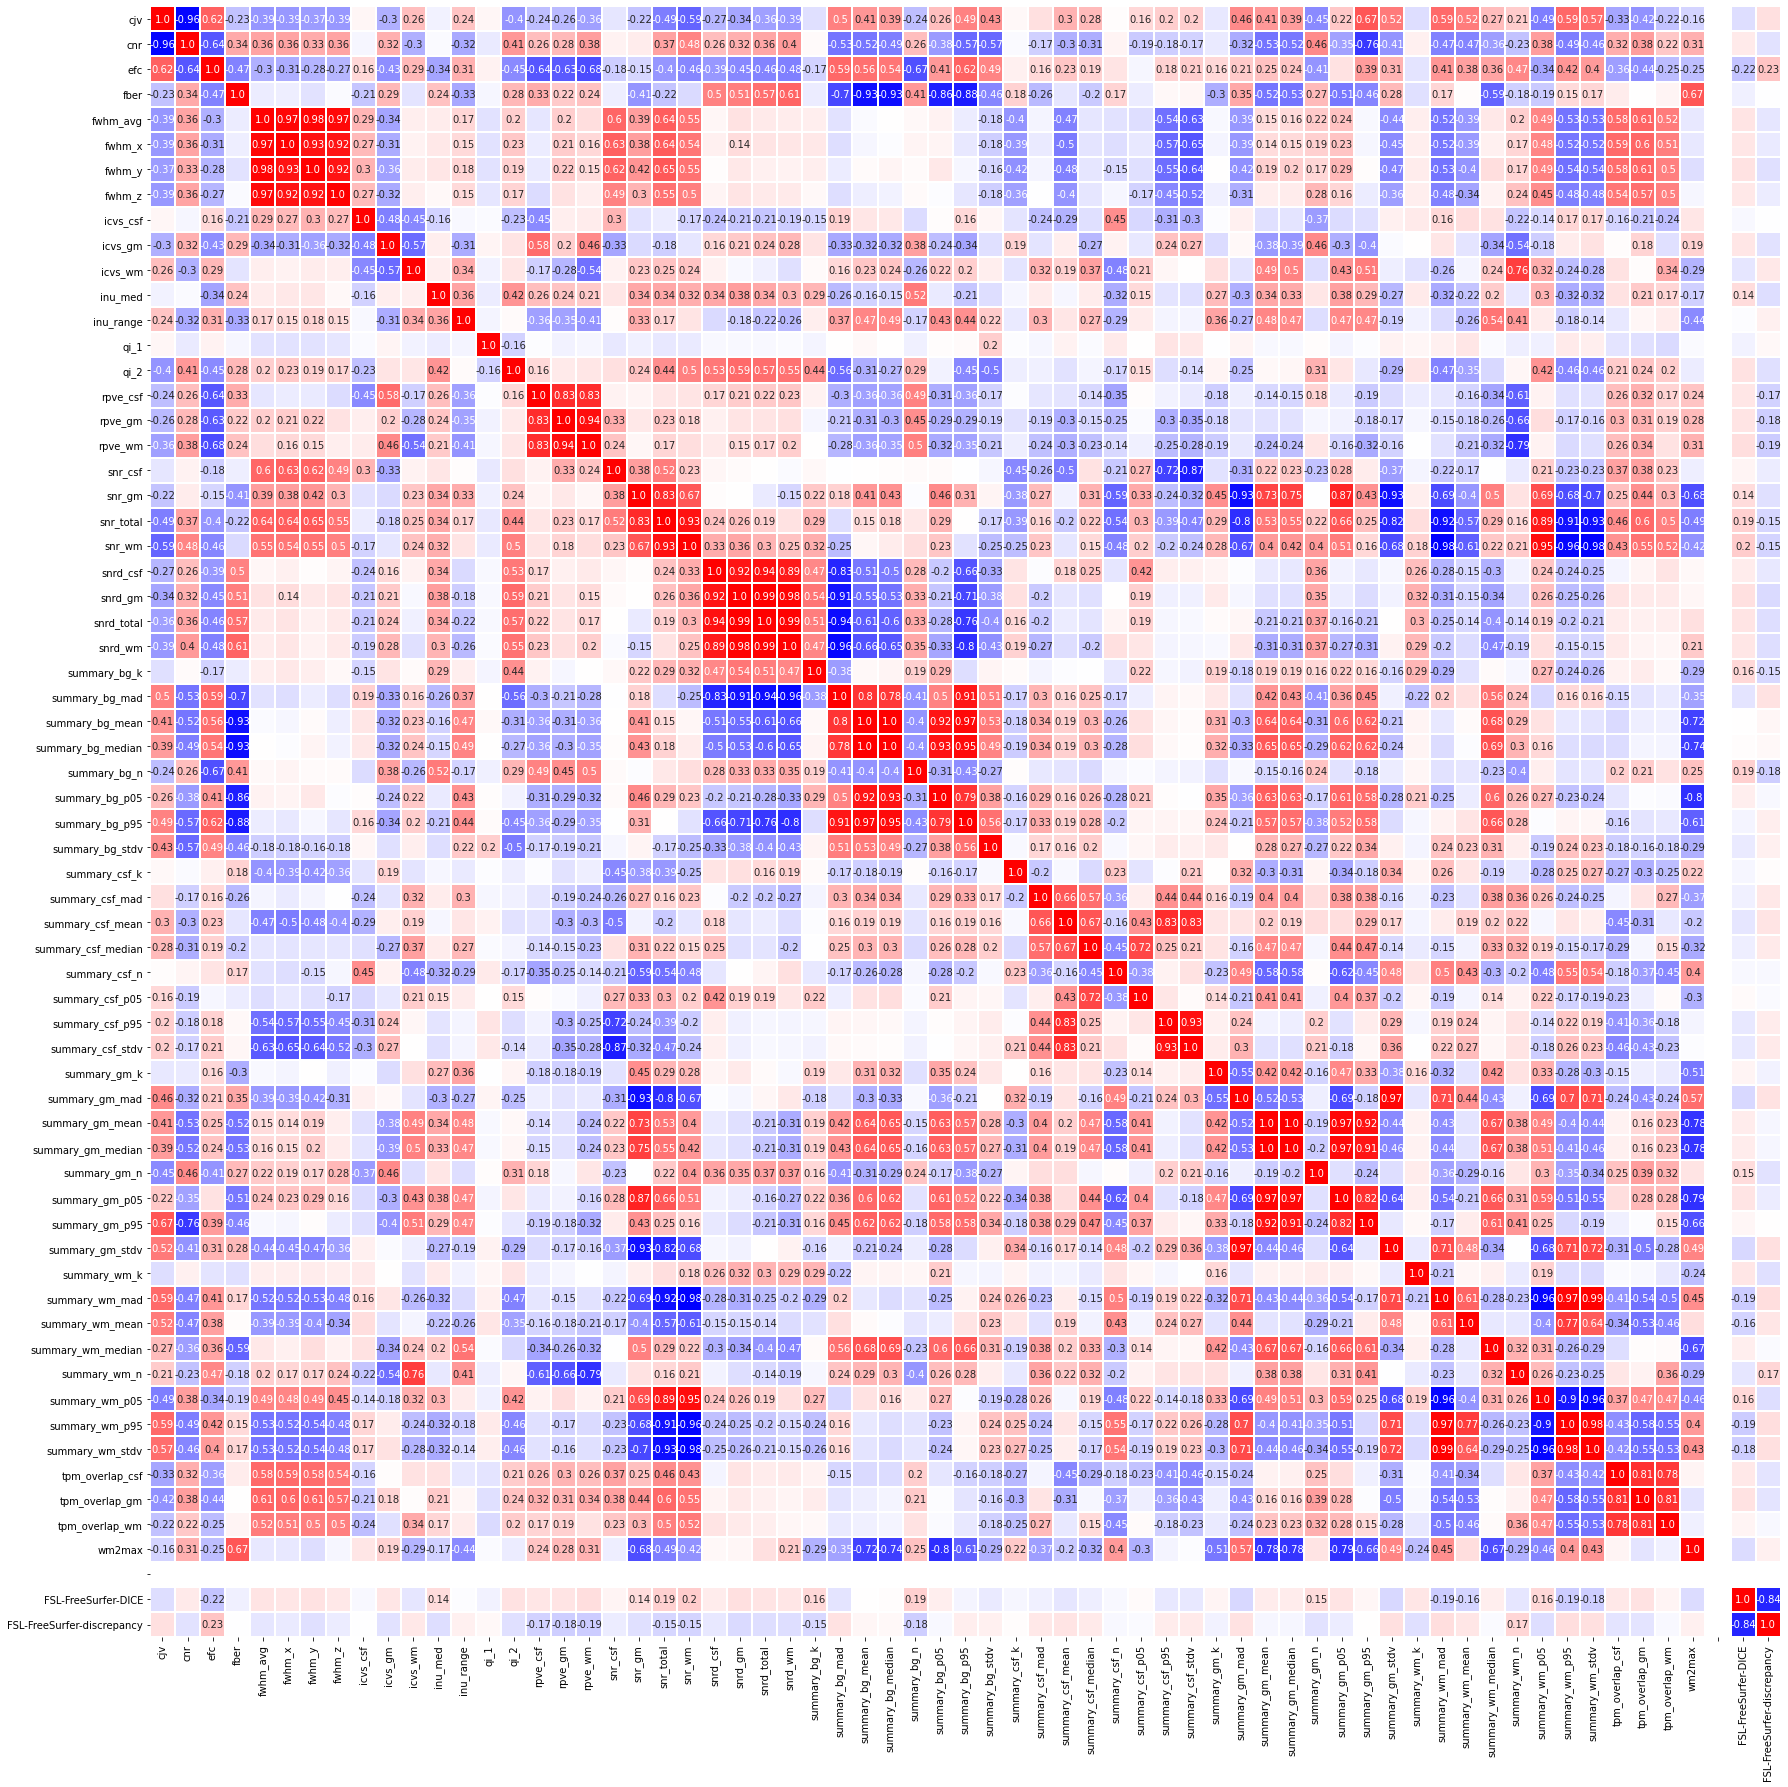

In [12]:
import scipy.stats as ss
import pandas as pd

target_feature_key = 'FSL-FreeSurfer'

nan_var = np.zeros_like(target[target_feature][target_feature_key][None,:])
B = np.concatenate((observations.T, nan_var, target['DICE'][target_feature_key][None,:], target['discrepancy'][target_feature_key][None,:]), axis=0)
C = np.corrcoef(B)

p_values = np.zeros_like(C)
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        p_values[i,j] = ss.pearsonr(B[i,:], B[j,:])[1]

name_lst = list()
name_lst = [item for item in features_list]
name_lst.append('')
name_lst.append(target_feature_key+'-'+'DICE')
name_lst.append(target_feature_key+'-'+'discrepancy')

N = C.shape[0] - 1
alpha = 0.05
alpha_corrected = alpha / (N*(N-1)/2)
significant_corrs = p_values < alpha_corrected
df = pd.DataFrame(np.multiply(C, significant_corrs))
labels = df.applymap(lambda v: str(round(v,2)) if v != 0.0 else '')

fig, ax = plt.subplots(figsize=(30,30))
im = sns.heatmap(C, 
            annot=labels, fmt="", cmap='bwr', 
            xticklabels=name_lst, yticklabels=name_lst, 
            cbar=False,
            square=True, linewidth=2, linecolor='w'
        )


*** correlation of the top feature -efc- with FSL-FreeSurfer discrepancy = -0.23


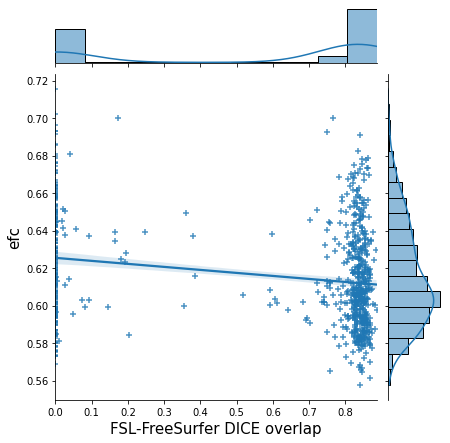

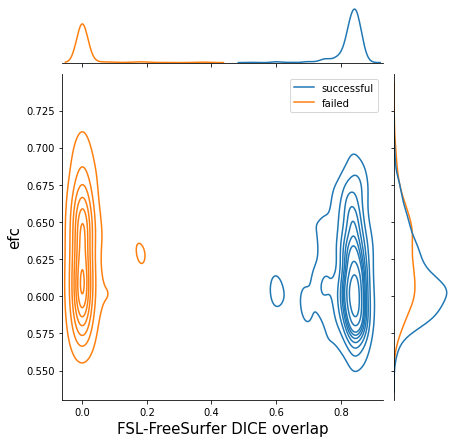

In [14]:
for target_feature_key in target[target_feature]:

    # scatter plots
    x = target[target_feature][target_feature_key]
    y = observations[:, top_feature[target_feature_key]['idx']]
    h = sns.jointplot(x=x, y=y, kind="reg", marker="+")

    # JointGrid has a convenience function
    if target_feature == 'discrepancy':
        h.set_axis_labels(target_feature_key+' discrepancy ('+r'$mm^3$'+')', top_feature[target_feature_key]['name'], fontsize=15)
    elif target_feature == 'DICE':
        h.set_axis_labels(target_feature_key+' DICE overlap', top_feature[target_feature_key]['name'], fontsize=15)

    plt.savefig(target_feature_key+'-'+target_feature+"-output-scatter.png", transparent=True)

    # 2-class scatter plots
    x = target[target_feature][target_feature_key]
    y = observations[:, top_feature[target_feature_key]['idx']]
    hue = list()
    if target_feature=='DICE':
        threshold = 0.5
        for j in range(len(target[target_feature][target_feature_key])):
            if target[target_feature][target_feature_key][j] > threshold:
                hue.append('successful')
            elif target[target_feature][target_feature_key][j] < threshold:
                hue.append('failed')
    elif target_feature=='discrepancy':
        threshold = 2000
        for j in range(len(target[target_feature][target_feature_key])):
            if target[target_feature][target_feature_key][j] < threshold:
                hue.append('successful')
            elif target[target_feature][target_feature_key][j] > threshold:
                hue.append('failed')
    h = sns.jointplot(x=x, y=y, hue=hue, kind="kde")

    # JointGrid has a convenience function
    if target_feature == 'discrepancy':
        h.set_axis_labels(target_feature_key+' discrepancy ('+r'$mm^3$'+')', top_feature[target_feature_key]['name'], fontsize=15)
    elif target_feature == 'DICE':
        h.set_axis_labels(target_feature_key+' DICE overlap', top_feature[target_feature_key]['name'], fontsize=15)

    plt.savefig(target_feature_key+'-'+target_feature+"-output-2class-scatter.png", transparent=True)

    # print correlation values of top correlated features
    print('*** correlation of the top feature -' + top_feature[target_feature_key]['name'] + '- with '+ target_feature_key +' discrepancy = %.2f' %top_feature[target_feature_key]['corr'])

In [ ]:
for target_feature_key in target[target_feature]:

    for i, feature in enumerate(features_list):
        # scatter plots
        x = target[target_feature][target_feature_key]
        y = observations[:, i]
        hue = list()
        for j in range(len(target[target_feature][target_feature_key])):
            if target[target_feature][target_feature_key][j] > 0.5:
                hue.append('successful')
            elif target[target_feature][target_feature_key][j] < 0.5:
                hue.append('failed')
        h = sns.jointplot(x=x, y=y, hue=hue, kind="kde")
        # h = sns.jointplot(x=x, y=y, hue=hue, marker="+")

        # JointGrid has a convenience function
        if target_feature == 'discrepancy':
            h.set_axis_labels(target_feature_key+' discrepancy ('+r'$mm^3$'+')', feature, fontsize=15)
        elif target_feature == 'DICE':
            h.set_axis_labels(target_feature_key+' DICE overlap', feature, fontsize=15)